### Цели работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием  `pyspark`

### Задачи работы
Выполнить разведочный анализ датасета с определением:
   * типов признаков в датасете;
   * пропущенных значений и их устранением;
   * выбросов и их устранением;
   * расчетом статистических показателей признаков (средних, квартилей и т.д.);
   * визуализацией распределения наиболее важных признаков;
   * корреляций между признаками

### **1. Запуск фреймворка PySpark и загрузка данных** 

In [5]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pylab 
import seaborn as sns
import scipy.stats as scipy_stats
from scipy.stats import probplot

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [6]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row, DataFrame, SparkSession, SQLContext, functions, Window
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import skewness, lit, desc, col,when, size, array_contains, row_number, \
isnan, udf, hour, array_min, array_max, countDistinct, median, collect_list, \
max, mean, min, stddev, monotonically_increasing_id  
from pyspark.sql.types import *

MAX_MEMORY = '10G'

# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'itineraries1M.csv'

# Load the main data set into pyspark data frame 
df = spark.read.options(inferSchema='True', header='True', delimeter=',').csv(filename_data, mode='DROPMALFORMED')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### 2. Обзор датасета itineraries 

Датасет содержит информацию о ценах на полеты в одну сторону самолетами согласно Expedia на период с 16.04.2022 до 05.10.2022.

Датасет представляет собой CSV-файл, где каждая строка - купленный билет в/из следующих аэропортов: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK.

Определения столбцов:
* legId: Идентификатор рейса.
* searchDate: Дата (ГГГГ-ММ-ДД), когда эта запись была взята из Expedia.
* flightDate: Дата (ГГГГ-ММ-ДД) полета.
* startingAirport: Трехсимвольный код аэропорта IATA для начального местоположения.
* destinationAirport: Трехсимвольный код аэропорта IATA для места прибытия.
* fareBasisCode: Код основного тарифа.
* travelDuration: Продолжительность поездки в часах и минутах.
* elapsedDays: Количество прошедших дней (обычно 0).
* isBasicEconomy: Булево значение, указывающее, предназначен ли билет для базовой экономики.
* isRefundable: Булево значение, указывающее, можно ли вернуть деньги за билет.
* isNonStop: Булево значение, указывающее, является ли рейс беспосадочным.
* baseFare: Цена билета (в USD).
* totalFare: Цена билета (в USD), включая налоги и другие сборы.
* seatsRemaining: Целое число для количества оставшихся мест.
* totalTravelDistance: Общее расстояние поездки в милях. Эти данные иногда отсутствуют.
* segmentsDepartureTimeEpochSeconds: Строка, содержащая время отправления (время Unix) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsDepartureTimeRaw: Строка, содержащая время отправления (формат ISO 8601: YYYY-MM-DDThh:mm:ss.000±[hh]:00) для каждого этапа поездки. Записи для каждого из этапов разделяются символом '||'.
* segmentsArrivalTimeEpochSeconds: Строка, содержащая время прибытия (время Unix) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsArrivalTimeRaw: Строка, содержащая время прибытия (формат ISO 8601: YYYY-MM-DDThh:mm:ss.000±[hh]:00) для каждого этапа поездки. Записи для каждого из этапов разделяются символом '||'.
* segmentsArrivalAirportCode: Строка, содержащая код аэропорта IATA для места прибытия для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsDepartureAirportCode: Строка, содержащая код аэропорта IATA для места отправления на каждом этапе путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsAirlineName: Строка, содержащая название авиакомпании, обслуживающей каждый этап путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsAirlineCode: Строка, содержащая двухбуквенный код авиакомпании, обслуживающей каждый этап путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsEquipmentDescription: Строка, содержащая тип самолета, используемого на каждом этапе путешествия (например, "Airbus A321" или "Boeing 737-800"). Записи для каждого из этапов разделяются символом '||'.
* segmentsDurationInSeconds: Строка, содержащая продолжительность полета (в секундах) для каждого этапа путешествия. Записи для каждого этапа разделяются символом '||'.
*  segmentsDistance: Строка, содержащая пройденное расстояние (в милях) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
*  segmentsCabinCode: Строка, содержащая код салона для каждого этапа поездки (например, "coach"). Записи для каждого этапа разделяются символом '||'.

In [7]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [8]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001,...,1000001,1000001,1000001,1000001,1000001,1000001,981246,1000001,1000001,1000001
1,mean,None,None,None,None,None,0.1466968533031467,301.2289706110249,349.3993726208429,5.633167366832633,...,1.6524624220774121E9,None,None,None,None,None,None,10983.641149188627,1089.5283456691338,None
2,stddev,None,None,None,None,None,0.3538092872028495,219.604618031477,235.77036573340848,2.9594105299328315,...,1423592.1137919438,None,None,None,None,None,None,5167.727033782255,723.2210985803953,None
3,min,00000115f8d6a14453bcd1bbc90fbd0b,ATL,ATL,A0ATZNFC,P1DT12M,0,5.1,23.97,0,...,1650186900,2022-04-17T04:29:00.000-06:00,ABE||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1007||207,business
4,max,ffffca93f7396a1e6bfac059ffa5abf5,SFO,SFO,ZVAZZNN3,PT9H9M,2,3531.16,3810.6,10,...,1655469420||1655492220,2022-06-17T08:37:00.000-04:00||2022-06-17T14:5...,XNA||ORD,TTN||RDU,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9960,None||None||None,premium coach||premium coach||coach


There are total 1000001 row, Let print first 2 data rows:


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach


### 3. Обнаружение пропущенных значений и аномальных нулей

После получения первого представления о колонках, в первую очередь необходимо убедиться, имеет ли датасет какие-либо пропущенные и аномальные нулевые значения.
- Для строковых колонок проверим на `None` и `null`;
- Для числовых колонок, допускающих значения ноль, проверим на `None` и `NaN`;
- Для числовых колонок, недопускающих значения ноль, проверим на нули, `None` и `NaN`;
- Для булевых колонок проверим на `None` и `null`;
- Для колонок с датами проверим на `None` и `null`.

In [9]:
string_columns = [
    'legId', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 
    'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 
    'segmentsDistance', 'segmentsCabinCode'
]

numeric_with_zeroes_columns = ['elapsedDays', 'seatsRemaining']
numeric_without_zeroes_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']

date_columns = ['searchDate', 'flightDate']

missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns: # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_with_zeroes_columns: # check None, NaN and Null
        missing_count = df.filter(col(column) == None | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_without_zeroes_columns:  # check zeroes, None, NaN and Null
        missing_count = df.filter(col(column).isin([0,None]) | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in boolean_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in date_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

columns_with_missing_values = []
for column in missing_df:
    if missing_df[column].values[0] != 0:
        columns_with_missing_values.append(column)

missing_df[columns_with_missing_values]


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18755,0,0,0


,totalTravelDistance,segmentsEquipmentDescription
0,61860,18755


In [10]:
mean_value = df.agg(mean(df['totalTravelDistance'])).collect()[0][0]
mean_value

1579.0602777194472

In [11]:
df_fill = df.withColumn('totalTravelDistanceWasNull', when(df['totalTravelDistance'].isNull(), 1).otherwise(0))

In [12]:
df_fill=df_fill.na.fill(value=mean_value,subset=["totalTravelDistance"])
df_fill.select('totalTravelDistance','totalTravelDistanceWasNull').limit(10).toPandas()

,totalTravelDistance,totalTravelDistanceWasNull
0,947,0
1,947,0
2,947,0
3,947,0
4,947,0
5,947,0
6,956,0
7,956,0
8,956,0
9,956,0


In [13]:
print(f'Number of rows before deleting na values: {df.count()}')
df = df.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df.count()}')

Number of rows before deleting na values: 1000001
Number of rows after deleting na values: 921951


In [14]:
print(f'Number of rows before deleting na values: {df_fill.count()}')
df_fill = df_fill.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df_fill.count()}')

Number of rows before deleting na values: 1000001
Number of rows after deleting na values: 981246


### 4. Определение выбросов и удаление выбросов

Метод  Z-оценки

Z-оценка, или “стандартная оценка”, — это статистическая мера, которая показывает, на сколько стандартных отклонений наблюдаемая точка удалена от среднего значения. 
При использовании этого метода необходимо определить порог: если точка данных имеет значение, превышающее пороговое, то она является выбросом.

Вычисляем Z следующим образом:
    z = (X - μ) / σ
В этой формуле :
- X — значение точки данныхх;
- μ - среднее значения;
- σ - стандартное отклонение

    Метод Z-оценки имеет несколько недостатков:
* Его можно использовать только с одномерными данными (один столбец датафреймов, массивов, списков и т. д.);
* Он должен использоваться только с нормально распределенными данными;
* Исследователю придется определить порог, зависящий данных.

In [15]:
def z_estimation(df, column):
    #z_values_column_name = 'z'
    #row_idx_column_name = 'row_idx'
    
    data = np.array(df.select(collect_list(column)).first()[0])
    z = np.abs(scipy_stats.zscore(data))
    
    mean_value = df.agg(mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']
    

    lower_bound = mean_value - 3 * stddev_value
    upper_bound = mean_value + 3 * stddev_value
    
    filtered_df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return filtered_df

In [16]:
df_z = df
for column in numeric_with_zeroes_columns:
    df_z = z_estimation(df_z,column)
for column in numeric_without_zeroes_columns:
    df_z = z_estimation(df_z,column)

In [17]:
df.count()
df_z.count()

921951

902893

### 5. Расчет статистических показателей признаков

Рассчитаем следующие показатели:
- Минимальное ,cреднее и максимальное значения;
- Среднеквадратичное отклонение;
- Квартили;
- Коэффициент асимметрии;

In [18]:
def calculate_min_mean_max_statistic_indicators(df, column):
    min_value = df.agg(min(column).alias(f'min_{column}')).collect()[0][f'min_{column}']
    mean_value = df.agg(mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    max_value = df.agg(max(column).alias(f'max_{column}')).collect()[0][f'max_{column}']
    return (min_value, mean_value, max_value)

In [19]:
def calculate_stdev(df, column):
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']
    return stddev_value

In [20]:
def calculate_quartiles(df, column):
    q1, median, q3 = df.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    return q1, median, q3

In [21]:
def calculate_skewness(df, column):
    skewness_value = df.select(skewness(column).alias(f'skewness_{column}')).collect()[0][f'skewness_{column}']
    return  skewness_value

In [22]:
def calculate_statistical_indicators(df, column):
    min_value, mean_value, max_value =calculate_min_mean_max_statistic_indicators(df, column)
    stddev_value = calculate_stdev(df, column)
    q1, median, q3 = calculate_quartiles(df, column)
    skewness = calculate_skewness(df, column)
    return  (min_value, mean_value, max_value, stddev_value, q1, median, q3,skewness)

In [23]:
statistical_indicators = {}

for col in numeric_with_zeroes_columns:
    statistical_indicators[col] = calculate_statistical_indicators(df_z, col)

for col in numeric_without_zeroes_columns:
    statistical_indicators[col] = calculate_statistical_indicators(df_z, col)

for key, value in statistical_indicators.items():
    print(f"""
        Column: {key}
          -- Min: {value[0]}
          -- Mean: {value[1]}
          -- Max: {value[2]}
          -- Stddev: {value[3]}
          -- q1: {value[4]}
          -- q2(median): {value[5]}
          -- q3: {value[6]}
          -- skewness: {value[7]}
        """)


        Column: elapsedDays
          -- Min: 0
          -- Mean: 0.13957024808033733
          -- Max: 1
          -- Stddev: 0.34654080125940084
          -- q1: 0.0
          -- q2(median): 0.0
          -- q3: 0.0
          -- skewness: 2.0801588165497784
        

        Column: seatsRemaining
          -- Min: 1
          -- Mean: 6.011764406192096
          -- Max: 10
          -- Stddev: 2.67387491912083
          -- q1: 4.0
          -- q2(median): 7.0
          -- q3: 9.0
          -- skewness: -0.5592954628704976
        

        Column: baseFare
          -- Min: 8.72
          -- Mean: 291.18761168820663
          -- Max: 778.79
          -- Stddev: 151.02456272202048
          -- q1: 166.51
          -- q2(median): 268.84
          -- q3: 388.84
          -- skewness: 0.5636390929105163
        

        Column: totalFare
          -- Min: 23.97
          -- Mean: 335.13458490667045
          -- Max: 852.11
          -- Stddev: 164.58027051764094
          -- q1: 199.

### 6. Визуализацией распределения наиболее важных признаков

In [28]:
def plot_histogram(df, column):
    sampled_df = df.sample(fraction=0.6, seed=42)
    data = sampled_df.rdd.map(lambda row: row[column]).collect()
    #data = df.select(collect_list(column)).first()[0]
    data = sampled_df.rdd.map(lambda row: row[column]).collect()
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', color='blue')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    
    plt.show()

In [29]:
def plot_boxplot(df, column):
    sampled_df = df.sample(fraction=0.6, seed=42)
    data = sampled_df.rdd.map(lambda row: row[column]).collect()
    #data = df.select(collect_list(column)).first()[0]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, vert=False)  # vert=False для горизонтального ящика

    plt.title(f"Box plot of '{column}'")
    plt.xlabel(column)
    plt.show()

In [30]:
def pie_chart(df, column):
    sampled_df = df.sample(fraction=0.6, seed=42)
    pandas_df = sampled_df.groupby(column).count().toPandas()
    pandas_df = pandas_df.set_index(pandas_df.columns[0])
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect='equal'), dpi=120)

    data = pandas_df['count']
    categories = pandas_df.index

    plt.pie(data, labels = categories, autopct="%1.1f%%")
    ax.set_title(f"Pie Chart '{column}'")
    plt.show()

Column: elapsedDays


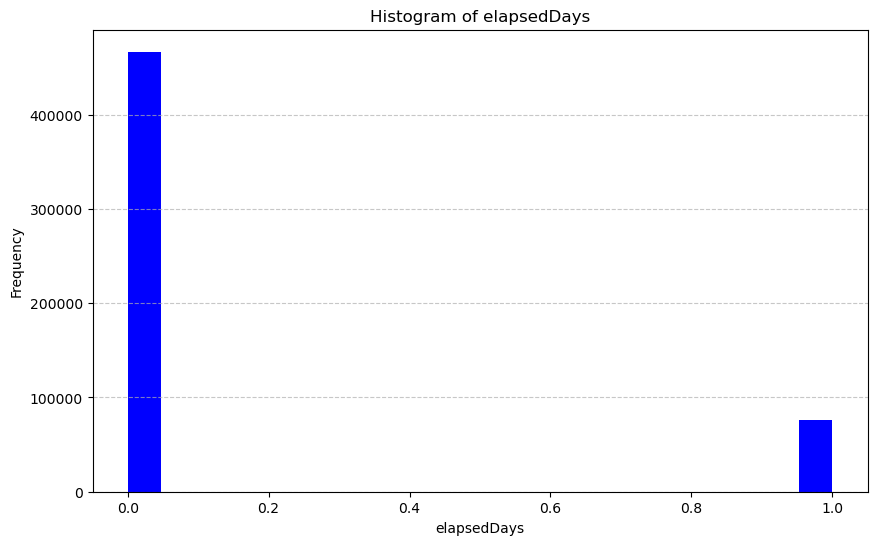

Column: seatsRemaining


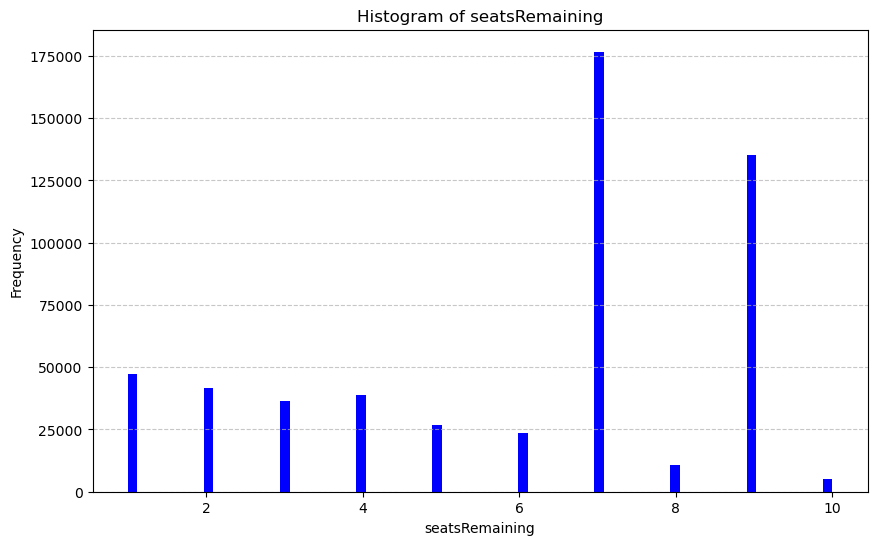

Column: baseFare


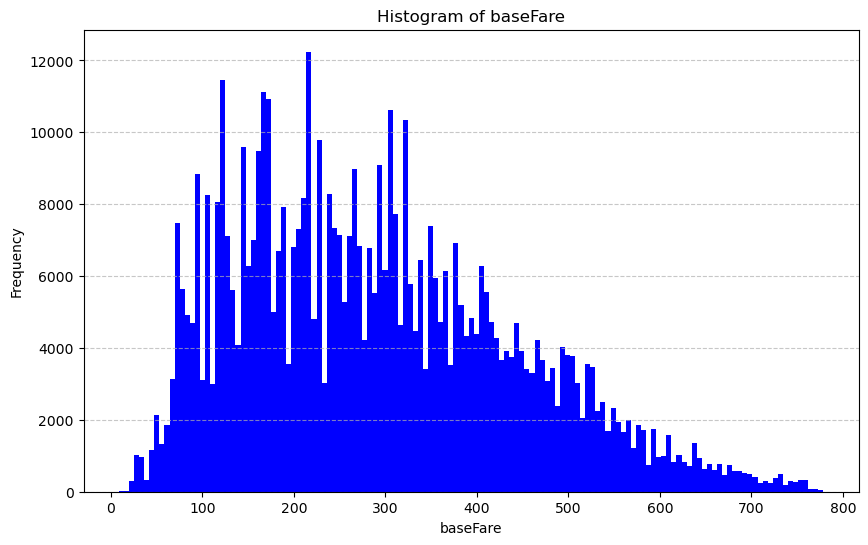

Column: totalFare


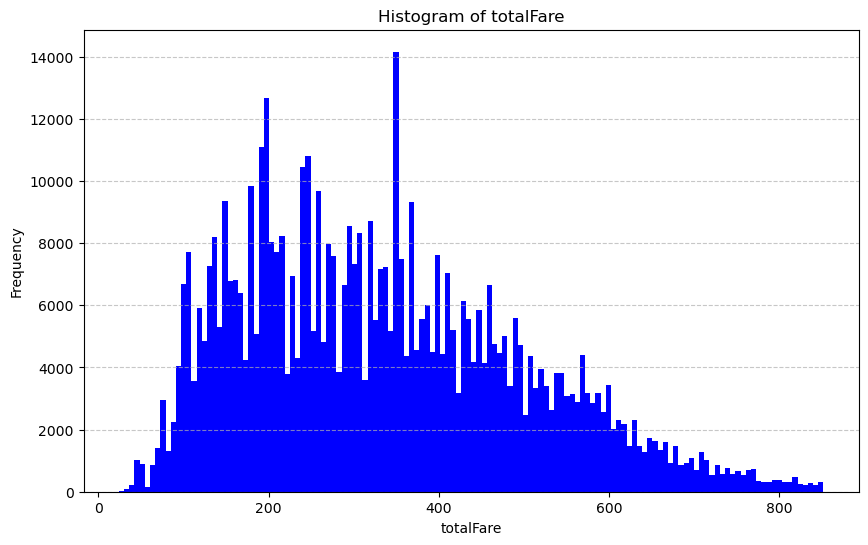

Column: totalTravelDistance


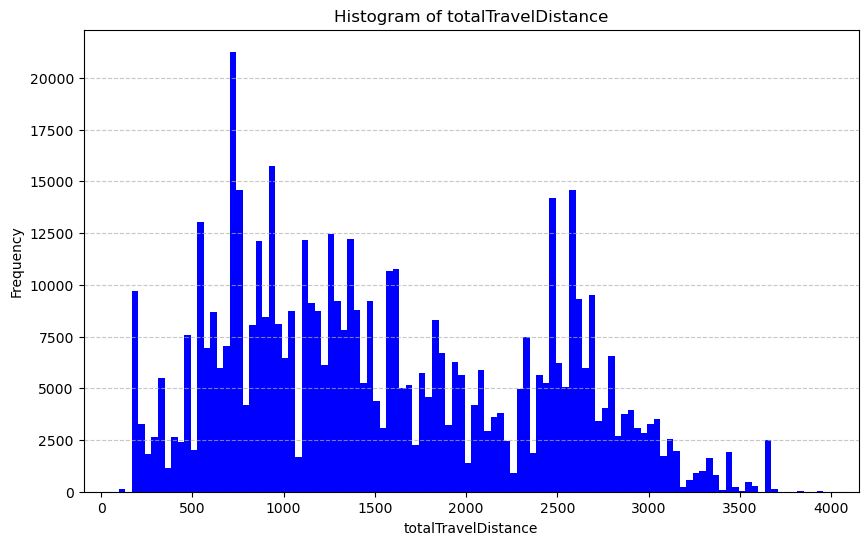

In [31]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(df_z, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(df_z, column)

Column: elapsedDays


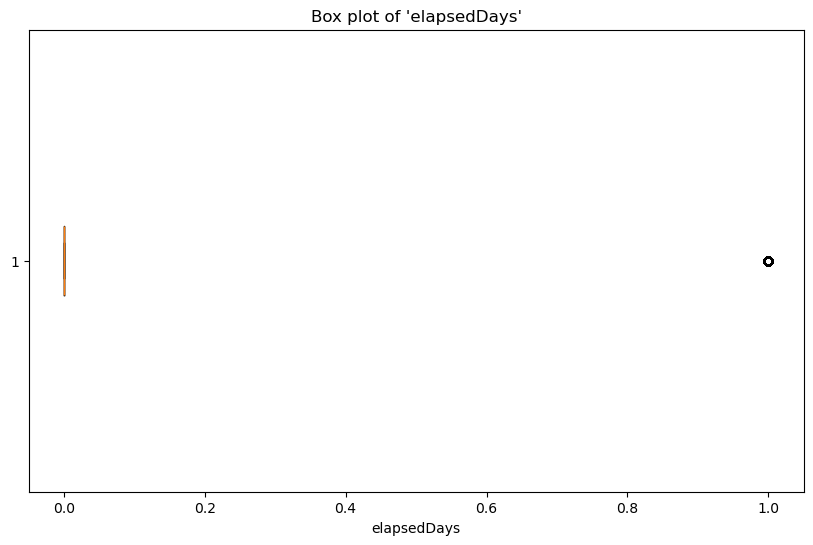

Column: seatsRemaining


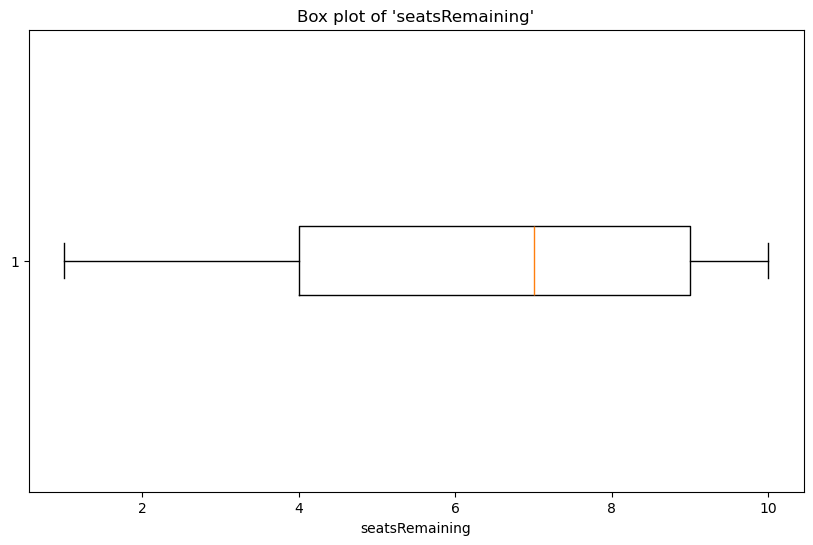

Column: baseFare


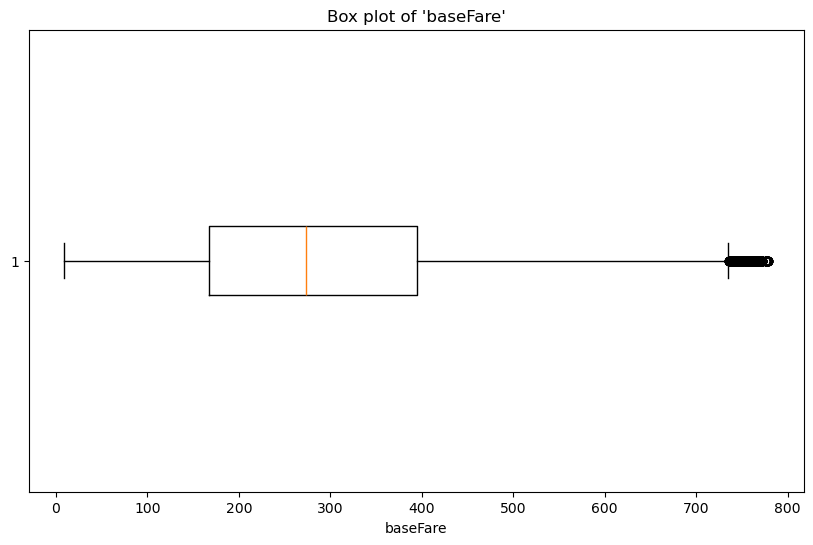

Column: totalFare


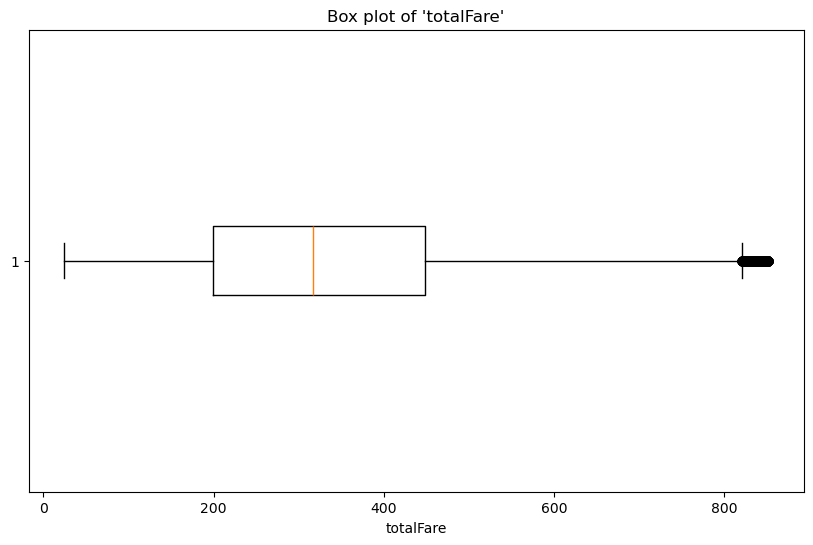

Column: totalTravelDistance


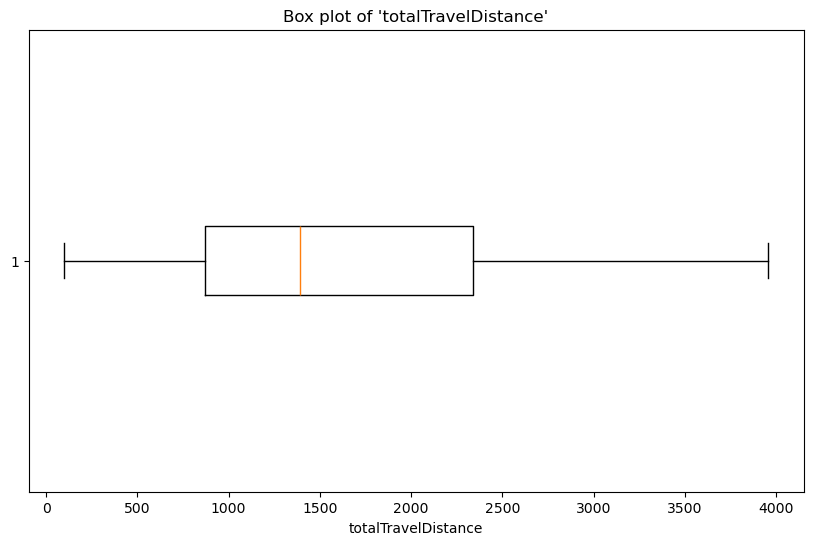

In [32]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(df_z, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(df_z, column)

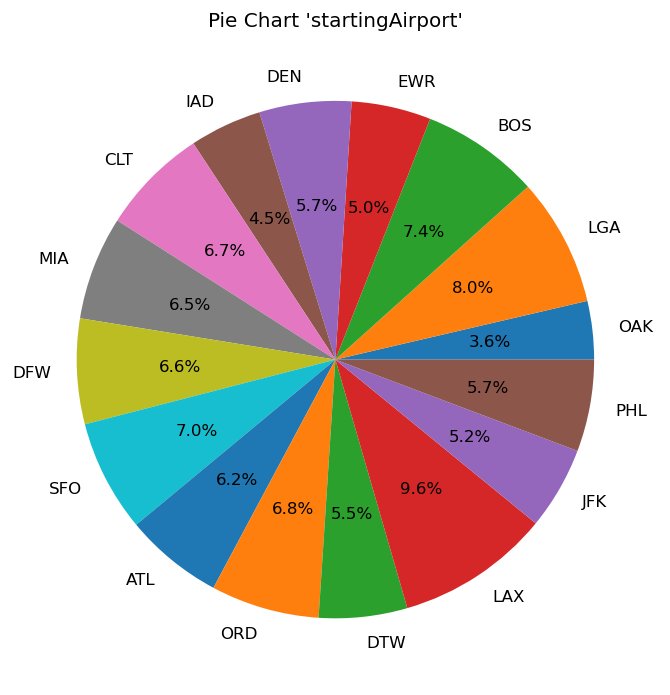

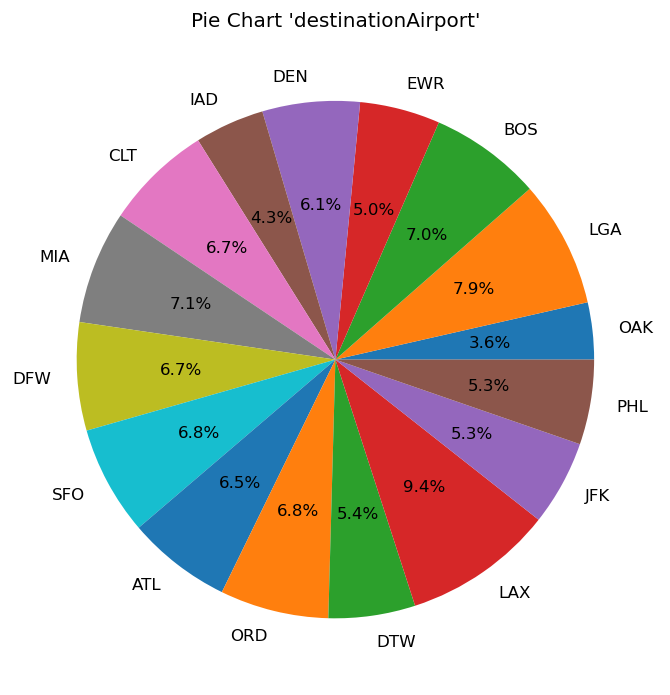

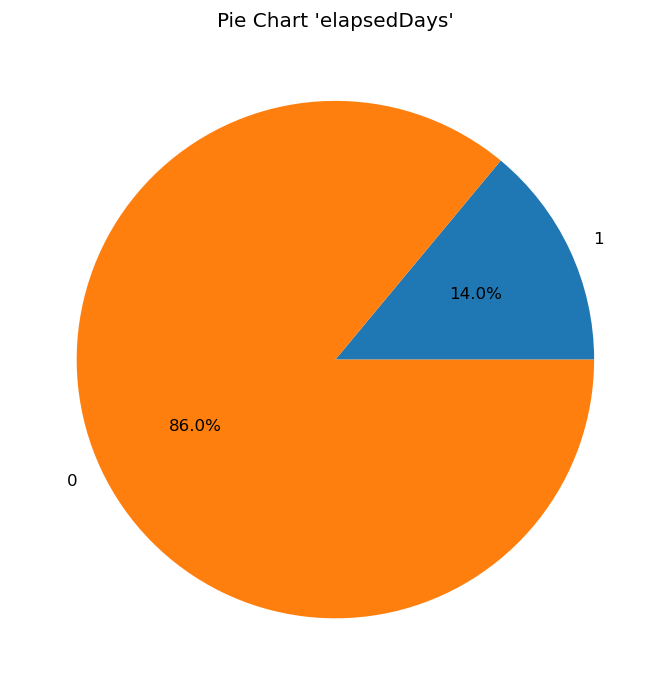

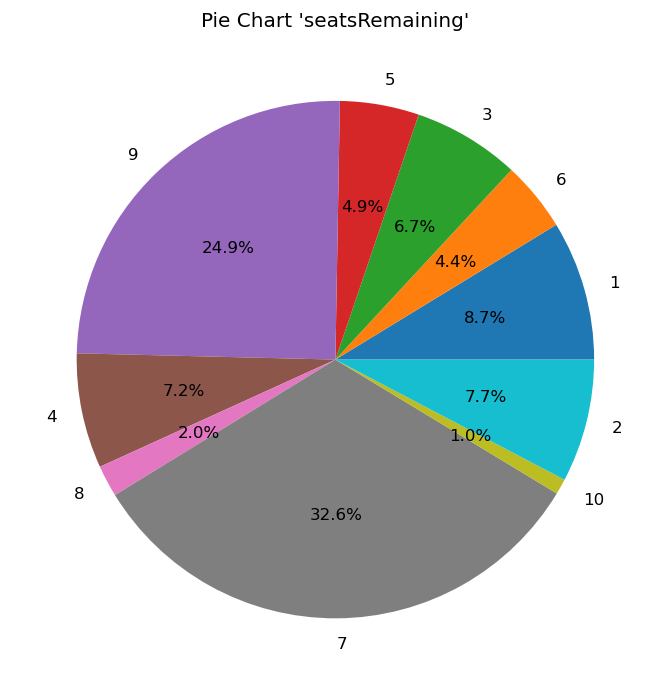

In [33]:
pie_chart(df_z, 'startingAirport')
pie_chart(df_z, 'destinationAirport')
pie_chart(df_z, 'elapsedDays')
pie_chart(df_z, 'seatsRemaining')

### 7. Корреляций между признаками

<Figure size 1600x500 with 0 Axes>

<Axes: >

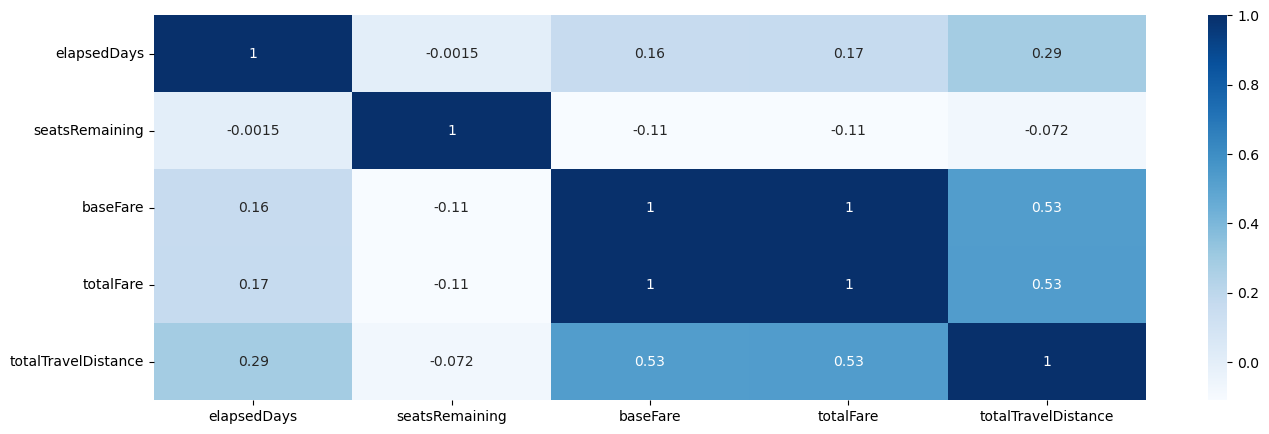

In [34]:
vector_col = 'corr_features'
numeric_columns = numeric_with_zeroes_columns + numeric_without_zeroes_columns

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(df_z).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=numeric_columns, index=numeric_columns) 

plt.figure(figsize=(16,5))  
sns.heatmap(
    corr_matrix_df, 
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,  
    cmap='Blues', 
    annot=True
)

Из корреляционной матрицы видно , что baseFare и totalFare демонстрируют тесную положительную взаимосвязь, поскольку цена билета всегда включает одну и ту же сумму налогов.

#### Вывод

В ходе работы ознакомился с понятием «большие данные» и способами их обработки. Познакомилсяя с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данны. П Получить навыки выполнения разведочного анализа данных использованием `pyspark`.

In [35]:
#output_file_path = "itinerariesClear.csv"
#df_fill.write.csv(output_file_path, header=True, mode="overwrite")